# Behavioral Cloning Project

### _The best advice to those about to embark on a very large simulation is often the same as Puch's famous advice to those about to marry:  Don't_
                                                                                          --Bratley, Fox and Schrage

The goals / steps of this project are the following:

- Use the simulator to collect data of good driving behavior
- Build, a convolution neural network in Keras that predicts steering angles from images
- Train and validate the model with a training and validation set
- Test that the model successfully drives around track one without leaving the road
- Summarize the results with a written report

---
# Writeup
Below I will consider the [rubric points](https://review.udacity.com/#!/rubrics/432/view) individually and describe how I addressed each point in my implementation.

---
# A. File Submition & Code Quality

My project includes the following files:

- **This ipython notebook**: 
    - containing code snippits used to create and train & save the model as well as the report.
    - It also shows the pipeline I used for training and validating the model
    - contains various comments to explain how the code works.
    
- **drive.py** for driving the car in autonomous mode. Various driving parameters can be set there.
- **my_model.py** the python code used to produce the results
- **vedio.py** python code to generate the resulting vedio of the autonomos driving based on the generated .h5 files.
- **writeup_report.htlm**.A handy version of this notebook with all cell executed that summarize the results for easy review

- **saved_model.h5** containing a trained convolution neural network
- ** run1.mp4 ** a vedio of the car driving track1 autonomously





# B. Model Architecture and Training Strategy In a Nutshell

## 1. General Model Description

- The model consists of a number of consecutive convolution layers with various filter sizes and depths to capture different information that are encoded at different levels.
- The model utilizes subsampling and applies Max Pooling.
- The model includes RELU layers to introduce nonlinearity.
- Data is normalized in the model using a Keras lambda layes.


## 2. Handling overfitting 

- Two dropout layers were introduced in order to reduce overfitting. [Reference](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- The model was trained and validated on different data sets to ensure that the model was not overfitting. Data shuffling was introduced to maximise the gain of such process.
- The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.
- The use of [Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf) layers may be invistigated in future work.

## 3. Model parameter tuning

- The model used an adam optimizer, so the learning rate was not tuned manually.
- The number of epochs were chosen to achieve the given objective without overfitting the model.

## 4. Appropriate training data

- Training data was chosen to keep the vehicle driving on the road. I used a combination of center lane driving, recovering from the left and right sides of the road.
- For details about how I created the training data, see the next section.


Below I start by importing necessary functions, load and perform various preprocessing on the Data.


----
# Necessary Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import csv
import time

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D


%matplotlib inline

Using Theano backend.


# Data Exploration & Preperation

## 1. Extracting Data from CSV file
- The accompyning .csv file contains all needed information about the trained data
- For every image I load, I labeled that image with its associated steering angle found at index[3] of the line read by the csv file. various lists are used to store such results.
- To concentrate on the road and by looking at the images, the top 70 pixels and the bottom 20 pixels might be cropped. This enahnces the model accurecy 


The following was observed by training small sample set:

- if the car steeply steers to either right or left, it stays there given the set of training images. To work around this problem:
    - Either specific data of recovery ,by driving the car in such circumstances, should be added to the training set. OR
    - Utilizing information provided by left and right cameras

Here, I utilzed the second approach:

- It is worth mentioning that steering taken for left and right camera images was considered with respect to the image captured at the center. At this stage I am utilizing a fixed value. 
- For training, I utilized data that was provided by udacity with some extra processing. I have not collected data myself, although, I very much enjoyed playing the game. :)

### The use of generators
- In order to get the model to produce good results, lot of images have to be considered for training. Unfortunately, and by using the normal function loading, memory soon gets exhusted and the speed of training drops dramatically. To handle this issue, I utilized python generators that enable loading chunk of data to memory on demand by keeping the sttus of the last run. The following gentle introduction the the topic was suggested by one of forum mentors. [Link](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)
- Below is code to yield the next training batch:

In [2]:
def my_generator(lines, batch_size=32):
    N = (len(lines)//batch_size)*batch_size  # make the number of samples in 'lines' a multiple of batch_size

    X_batch = np.zeros((batch_size, 160, 320, 3), dtype=np.float32)
    y_batch = np.zeros((batch_size,), dtype=np.float32)
    
    while True:
        for i in range(0, N, batch_size):
            batch_start = i
            batch_stop = i + batch_size
            batch_lines = lines[batch_start:batch_stop]

            for j, line in enumerate(batch_lines):
                
                source_path = line[0]
                tokens = source_path.split('/')
                filename = tokens[-1]
                local_path = './data/IMG/'+filename
                
                image = mpimg.imread(local_path)
                steering = float(line[3])

                X_batch[j] = image
                y_batch[j] = steering
           
            yield (X_batch, y_batch)

---
## 2. Data Preprocessing

- Many of the images favours left steering because the training data was initially prepared by driving the car counter clockwise. Two suggested solutions:
    - Add more training data by driving the car in the opposite direction
    - Augmenting data by fliping images to the left.

Here I will consider the second approach, the following function was used for that purpose


In [3]:
def flip(image,steering):
    
    flipped_image = cv2.flip(image, 1) #flip around the vertical axes
    steer_value =  steering * -1.0  #flip the steering angles
    
    return flipped_image, steer_value

- Further more, and to account for various road conditions, some random white noise was added to the images that taken from the central camera.  
- The code was utilized from the forum(references above) and it is self explonatory. 

In [4]:
def augment_brightness_camera_images(image):
    '''
    :param image: Input image
    :return: output image with randomly adjusted brightness
    '''

    # convert to HSV so that its easy to adjust brightness
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .25+np.random.uniform()

    # Apply the brightness reduction to the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

**It is worth mentioning that many other techniques could also be used to generate additional images and or, emphisize certain features. Nevertheless, the above two codes seem to function properly, at least for the simple track.**



## Random Visualization
the follwoing line of code was used to generate random images and show them. show image function is presnted in the appendix.

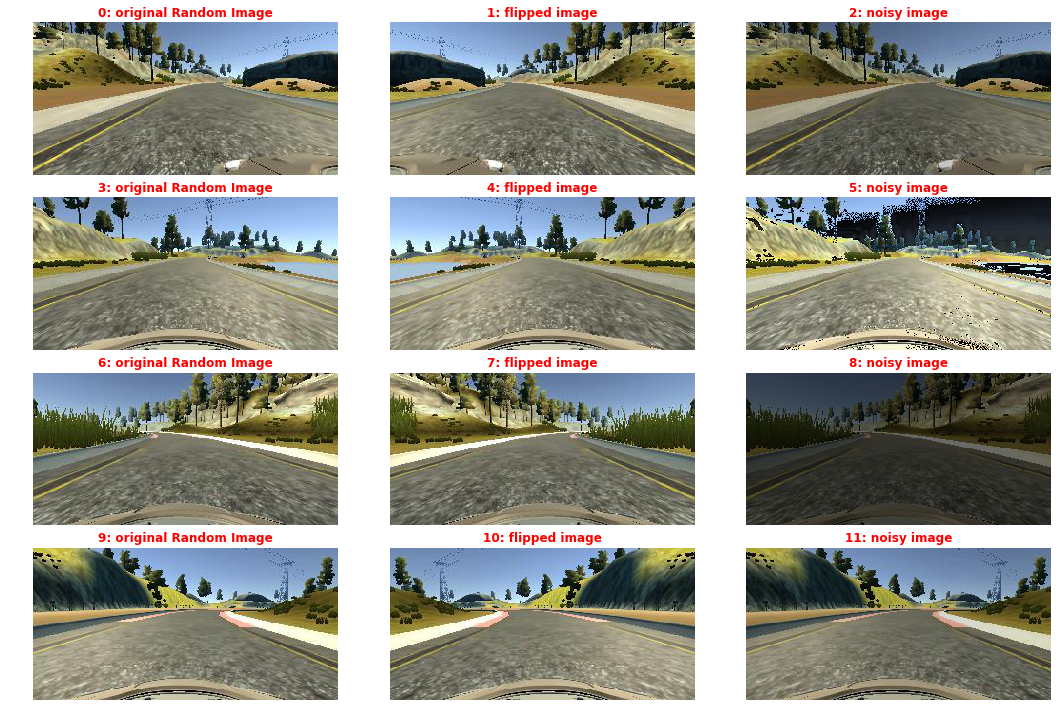

In [45]:
import random

num_show_imgs = 4

indx = random.sample(range(1,  len(images)), num_show_imgs)

show_list = []

for i in indx:
    car_image = images[i]
    flip_img,s = flip(car_image)
    noisy = augment_brightness_camera_images(car_image)
    
    show_list.append(car_image)
    show_list.append(flip_img)
    show_list.append(noisy)

titles = ['original Random Image', 'flipped image', 'noisy image']

main_titles = titles*num_show_imgs

show_images(np.array(show_list), np.array(main_titles), (15,10), size = (4,3) )
plt.savefig('0_RandomImageShow.png')

---
## 3. Data Training 

- To choose a good architecture and to speed up the testing process, I initially utlized a small subset of the training data and later generalized the obtained parameters based on some educated guess.
- Data shuffling and randomization as well as splitting is handled explicitly by Keras Functions. When necessary, comments were added to the corrosponding code line
- The training set includes maneuvers that keep the car away from the lane line and make sure that the car stays on the road throughout the simulation.
- The code for performing this task is presented in the context when describing the arhitecture
- Here I present the code I finally used to load data and preprocess it. It is self explanatory


In [5]:
def my_generator(lines, batch_size=32):
    N = (len(lines)// batch_size)*batch_size  # make the number of samples in 'lines' a multiple of batch_size
    
    correction = 0.16
    
    while True:
        for i in range(0, N, batch_size):
            
            images = []
            steer_values = []
            
            batch_start = i
            batch_stop = i + batch_size
            batch_lines = lines[batch_start:batch_stop]

            for j, line in enumerate(batch_lines):
                
                for i in range(3): # considering the input of all three cameras
    
                    source_path = line[i] # 0-center image, 1-left image, 2-right image
                    tokens = source_path.split('/')
                    filename = tokens[-1]
                    local_path = './data/IMG/'+filename

                    image = mpimg.imread(local_path)
                    
                    # crop
                    image = image[50:135,:,:]  #50-135

                    # resize
                    image = cv2.resize(image, (64, 64))
                    
                    #augment some addtional data
                    
                    noisy_img = augment_brightness_camera_images(image)
                
                    steer_reading = float(line[3])  #steering
                
                
                    if(i==1):
                        steer_reading = steer_reading + correction # adjust left image from the center
                    
                    elif(i==2):   
                        steer_reading = steer_reading - correction # adjust right image from the center
                         
                        
                    flipped_img, flipped_steer = flip(image,steer_reading)
                    
                    images.append(image)
                    images.append(noisy_img)
                    images.append(flipped_img)
                    
                    steer_values.append(steer_reading)
                    steer_values.append(steer_reading) # for noisy image
                    steer_values.append(flipped_steer)
                    
             
            yield (np.array(images), np.array(steer_values))

---

In [6]:
from sklearn.model_selection import train_test_split
lines = []

with open('data/driving_log.csv') as file:
    reader = csv.reader(file)
    next(reader, None)  # skip the headers
    
    for line in reader:
        lines.append(line)
        
        
line_sub = lines[:200]

train_lines, val_lines = train_test_split(line_sub, test_size=0.2)

print("The length of augmented car list is: ", len(train_lines))
print("The length of augmented measurement vector is: ", len(val_lines))

training_generator = my_generator(train_lines)
valid_generator = my_generator(val_lines)

The length of augmented car list is:  160
The length of augmented measurement vector is:  40


---
# C. Architectural Model Details

## 1. Solution Design Approach

The overall strategy for deriving a model architecture was to start with well known models and apply transfer learning by accounting for both: 
1. the amount of similarity in training data
2. the size of data set.

My first step was to use a convolution neural network model similar to the **LeNet**. 
- I used it as a starting point to get a feeling on how the simulator might perform. 
- I thought this model might be appropriate because of both its simplicity and richness. It allowed me to examine the effect of combining convolutional nets, sampling layers and various fully connected layers, and see how this combination influences simulator learning. 

        I utilized the results of the previous experiments to mainly add more training augmented data
        
- I found that my first model had a low mean squared error on the training set but a high mean squared error on the validation set. This implied that the model was overfitting.


My second guess was to try a closer related network introduced by **NVidia** at their article [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) and see how it performs on the simulator. 

---
       
As mentioned before, ADAM optimizater was used to minimize the loss function: **MSE**. A simple tf.train.GradientDescentOptimizer could equally be used, but would require more hyperparameter tuning before it would converge as quickly. Here are some points about ADAM optimizer. (Thanks to Udacity team):

1. The tf.train.AdamOptimizer uses Kingma and Ba's Adam algorithm to control the learning rate. 
2. Adam offers several advantages over the simple tf.train.GradientDescentOptimizer. 
    - Foremost is that it uses moving averages of the parameters (momentum). This enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning.
    
3. The main down side of the algorithm is:
    - requires more computation to be performed for each parameter in each training step (to maintain the moving averages and variance, and calculate the scaled gradient); 
    - requires more state to be retained for each parameter (approximately tripling the size of the model to store the average and variance for each parameter). 



In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. 

The final step was to run the simulator to see how well the car was driving around track one. There were a few spots where the vehicle fell off the track, especially on steep turns. To improve the driving behavior in these cases, I utilized more data and augmented the original data with additional information. The details were described earlier.

At the end of the process, the vehicle is able to drive autonomously around the track without leaving the road.



## 2. Final Model Architecture

The final model architecture, which is presented next, consisted of 5 convolutional layers followed by 3 fully connected ones. The model depects exactly the one provided by NVidai. It uses the same sizes, subsampling and pooling.
The visualization of the architecture as well as more detailed information can be found at [NVidia Article](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/ ). 
Here are the details of the layers:

1. Input layer 64x64x3
2. Covolution layer with 5x5 filter size and 2x2 stride and a new depth of 24. Followed by reLU activation
3. Max pooling layer
4. Covolution layer with 5x5 filter size and 2x2 stride and a new depth of 36. Followed by reLU activation
5. Drop out layer (0.2 drop)
6. Covolution layer with 5x5 filter size and 2x2 stride and a new depth of 48. Followed by reLU activation
7. Covolution layer with 3x3 filter sizeand a new depth of 64. Followed by reLU activation.
8. Covolution layer with 3x3 filter size and a depth of 64. Followed by reLU activation.
9. Drop out layer (0.1 drop)
10. Flatten layer
11. Fully connected dense layer of 100 columns.
12. Fully connected dense layer of size 100x50.
13. Fully connected dense layer of size 50x10 .
14. a single output dense layer

** The visualization of such a network is presented on the orignal paper link**









---
# Model Building


In [ ]:
model = Sequential()

#normalize data: [-0.5-0.5]
#model.add(Lambda(lambda x:x/255.0 -0.5, input_shape=(160,320,3)))   #original

model.add(Lambda(lambda x:x/255.0 -0.5, input_shape=(64,64,3)))   

#Perform some croping

#model.add(Cropping2D(cropping=((70,25),(0,0)))) #do not crop from left or right

model.add(Convolution2D(24,(5,5), strides=(2,2), activation='relu')) 
model.add(MaxPooling2D())
model.add(Convolution2D(36,(5,5), strides=(2,2), activation='relu')) 

model.add(Dropout(.25))

model.add(Convolution2D(48 ,(5,5), strides=(2,2), activation='relu'))
model.add(Convolution2D(64 ,(3,3), activation='relu'))
model.add(Convolution2D(64 ,(3,3), activation='relu'))

model.add(Dropout(.1))


model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

model.add(Dense(1)) #regression task


In [ ]:
t=time.time()

model.compile(optimizer='adam', loss='mse')
#model.fit(np.array(images), np.array(measurements), validation_split=0.2, shuffle=True, epochs=2)

model.fit_generator(training_generator, samples_per_epoch= len(train_lines), 
                    validation_data=valid_generator, nb_val_samples=len(val_lines), nb_epoch=1)

model.save('model.h5')

t2 = time.time()

print()
print(round((t2-t)/60.0, 2), 'Minutes to Craete & Save Simple Keras Model for 500 Sample Data...')

---
# A Note on the Creation of the Training Set & Training Process

1. I utilized all the provided training data. I also made the earlier described augmentations. Below, I mention some points that would enhance the learning procedure and enable driving the car in a more complex terrain.

2. Also a recording of the vehicle recovering from the left side and right sides of the road back to center should be carried out, so that the vehicle would learn to adjust once it deviates from the track

3. More tracks could be used to enhance the learning procedure.

4. Data augmentation should be considered to account for various road conditions. Example include, flipping the images and steering angles to capture some opposite turns.

5. The more collected data points, the better the accurecy.

6. Various well established techniques may be utilized in case of overfitting. These include the use of drop out and incorporating some statistical models like the Boltzman Machine. :) 

---
# Discussion

- Due to hardware limitations, enough samples only were utilized to generate the output. After all, I generated like 70000 images for training, but I used 10000. More accurate results could be achieved by training more samples and performing automatic check for model to stop training using [Model Check Point](https://keras.io/callbacks/#modelcheckpoint)
- I also tried visualizing the model using [Keras](https://keras.io/visualization/) but produced lot of well known error. I will fix this in other versions.
- It is worth mentioning that steering values the goes with images of the positoined left and right cameras were choosen huerstically  with respect to the images captured at the center. At this stage, a fixed value was assigned. This of course is a source of error especially at steep curves or a roundabout. more robust methods should be utilized to ensure a safe trip. :)
- Even when using generators or an explicit grapage collector [_**gc.collect()**_], memory was not freeing properly when running the code under jupyter notebook. It was not that much better when I ran the code from a .py file.  I was running anaconda 4. and already upgraded all included libraries.  I was able to run things normally, when I explicitly made theano uses the available GPU, i.e. forcing i.o transfer.  I think this is a sign of memory leak that needs to be further invistigated. 
- I wasted quite sometime with what appeared a common error but without good reported answeres with h5py.

                AttributeError: 'module' object has no attribute 'File' for h5py
                
    I only managed to solve that issue by uninstalling h5py, and install it again sololy using pip. It was a conflict issue with other files in theano.
    
    

- Given the many failing NN models that I experimented in this project and the previous one, I think I already developed a sense of what might work as a good architecture, what causes overfitting, underfitting and so on. Thanks for all the resources and the well explained material provided by Udacity. I appreciate providing me with any additional links to this interesting topic.

- I already appreciated how important it is to start with well known models and then build things from there. This is mandatory to create some feeling and experience on what models might work, given the fact that little is know about how NN produce fantastic results. Coming up with an excellent model is both science and art.

# Future Considerations
1. Driving the car at extreemly high speeds. :)
2. Reducing the speed when there is a steep turn. I mean no one presses the pedal when making a turn. We cannot challenge physics.
3. Dealing with some minor fluctuations when the car moves.
4. Considering other terrains.

## Acknowledgement
- Thanks to David for the information provided in the help session
- Thanks to the many useful suggestions provided at the well organized Udacity forum.
- Special thanks to the posts of @subodh.malgonde & @brenkenobi1990. [link](#https://discussions.udacity.com/t/using-generator-to-implement-random-augmentations/242185/9)



# Appendix
Here I present the codes I used in my initial attempts before using generators, by reading everything to memory. It is here for referencing puprposes. 

In [ ]:
#------------------------Loading Data -------------------------------
lines = []
measurements= []  
images = [] 

t=time.time()

with open('data/driving_log.csv') as file:
    reader = csv.reader(file)
    next(reader, None)  # skip the headers
    
    for line in reader:
        lines.append(line)


for line in lines:
    
    for i in range(3): # considering the input of all three cameras
    
        source_path = line[i] # 0-center image, 1-left image, 2-right image
        tokens = source_path.split('/')
        filename = tokens[-1]
        local_path = './data/IMG/'+filename
    
        img = mpimg.imread(local_path)
        images.append(img)
    
    correction = 0.15
    steer_reading = float(line[3])  #steering
    measurements.append(steer_reading)
    measurements.append(steer_reading + correction) # adjust left image from the center
    measurements.append(steer_reading - correction) # adjust right image from the center


print("The length of care list is: ", len(images))
print("The length of measurement vector is: ", len(measurements))

    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Load All Data...')

#------------Select A Random Image to Show--------------

indx = np.random.randint(0, len(images))

car_image = images[indx]

fig ,ax = plt.subplots(figsize=(7, 5))
  
ax.imshow(car_image)
ax.set_title("Random Captured Image", color ='r', fontweight='bold')
ax.axis('off')
ax.autoscale(False)

#---------- Data Augmentation----------------------------------
augmented_images = []
augmented_measurements = []

for image, measure in zip(images, measurements):
    
    augmented_images.append(image)
    augmented_measurements.append(measure)
    
    flipped_image = cv2.flip(image, 1) #flip around the vertical axes
    flipped_measure =  measure * -1.0  #flip the steering angles
    
    augmented_images.append(flipped_image)
    augmented_measurements.append(flipped_measure)
    
print("The length of augmented car list is: ", len(augmented_images))
print("The length of augmented measurement vector is: ", len(augmented_measurements))


#--------------------Training ------------------------
sample_size = len(augmented_images) #len(augmented_images))

cars = augmented_images[0:100]
steer_angle = augmented_measurements[1:sample_size] # ignoring labels

X_train = np.array(cars)
y_train = np.array(steer_angle)

In [21]:
def show_images(image_list, titles, plot_size, size = (2,2) ):
    
    """
    A handy function to display images
    """
    
    rows,cols = size[0], size[1]
    lables = titles.reshape(rows, cols)
    
    if(len(image_list[0].shape) > 2 ): # RGB Image
        
        img_width, img_hight, ch = image_list[0].shape
        images = image_list.reshape(rows,cols,img_width,img_hight,ch)
    else:
        img_width, img_hight = image_list[0].shape
        images = image_list.reshape(rows,cols,img_width,img_hight)
    
    
      
    f1, ax = plt.subplots(rows, cols ,figsize=plot_size)
    f1.tight_layout()
    f1.subplots_adjust(hspace=0.15)

    for i in range(rows):
        for j in range(cols):
            
            counter = i*cols +j
            ax[i][j].imshow(images[i][j],'gray')
            ax[i][j].set_title(str(counter)+": " + lables[i][j], color ='r', fontweight='bold')
            ax[i][j].axis('off')
    